## Cleaning notebook

This is where we cleaned the data and wrote the code that eventually ended up in cleaning.py

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [19]:
train = pd.read_csv('data/train.csv', parse_dates = True)
stores = pd.read_csv('data/store.csv')

/opt/anaconda3/envs/minicomp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Train dataframe

In [3]:
# count of null values in each column
train.isnull().sum()

Date                 0
Store            19301
DayOfWeek        19017
Sales            19027
Customers        19091
Open             19186
Promo            19194
StateHoliday     19254
SchoolHoliday    19337
dtype: int64

In [4]:
# Looking at rows where the target value (Sales) is missing. Can we derive it from the other columns?
train.loc[train.loc[:,'Sales'].isnull()].head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
19,2013-01-01,361.0,2.0,NaN,0.0,0.0,0.0,a,1.0
28,2013-01-01,352.0,2.0,NaN,0.0,0.0,0.0,a,1.0
62,2013-01-01,394.0,2.0,NaN,NaN,0.0,0.0,a,1.0
101,2013-01-01,287.0,2.0,NaN,0.0,0.0,0.0,a,1.0
134,2013-01-01,327.0,2.0,NaN,0.0,0.0,0.0,a,1.0


In [5]:
# Yes! If the store was closed, sales will be 0. If customer count is 0, sales will be 0. 
train.loc[(train.loc[:, 'Sales'].isnull()) & (train['Open'] == 0), 'Sales'] = 0
train.loc[(train.loc[:, 'Sales'].isnull()) & (train['Customers'] == 0), 'Sales'] = 0

# Same logic applies to customers.
train.loc[(train.loc[:, 'Customers'].isnull()) & (train['Sales'] == 0), 'Customers'] = 0

In [6]:
# Dropping remaining rows where target value (Sales) is missing. 
no_null_sales = train.loc[(train['Sales'].notnull()) | (train['Open'] == 0), :]
no_null_sales.loc[:,'Sales'].fillna(0, inplace=True)

# If we don't know which store the data is about, it won't be of much use either. Dropping. 
no_null_sales = no_null_sales.loc[no_null_sales['Store'].notnull(), :]

# Adding DayOfWeek feature.
no_null_sales.loc[:,'Date'] = pd.to_datetime(no_null_sales.loc[:,'Date'], format='%Y-%m-%d')
no_null_sales.loc[:,'DayOfWeek'] = no_null_sales.loc[:,'Date'].dt.weekday + 1

# Filling in missing values in the Open column based on whether there were any sales that day. 
no_null_sales.loc[(no_null_sales['Open'].isnull()) & (no_null_sales['Sales'] == 0),'Open'] = 0
no_null_sales.loc[(no_null_sales['Open'].isnull()) & (no_null_sales['Sales'] > 0),'Open'] = 1

/opt/anaconda3/envs/minicomp/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [7]:
no_null_sales.loc[:,'StateHoliday'].value_counts()

0      506204
0.0     60052
a       12406
b        4202
c        2109
Name: StateHoliday, dtype: int64

In [8]:
# Fixing data type inconsistency.
no_null_sales.loc[no_null_sales['StateHoliday'] == 0.0, 'StateHoliday'] = '0'
no_null_sales.loc[no_null_sales['StateHoliday'] == 0, 'StateHoliday'] = '0'

In [9]:
# Slow way to fill in missing values for StateHoliday and SchoolHoliday with the mode
# If 25th of December was Christmas in 1000 stores, we can assume it holds true where the value is NaN too. 
# TODO: Figure out fast, vectorized way to do this
holiday_nulls = no_null_sales.loc[no_null_sales['StateHoliday'].isnull()]
for i, row in holiday_nulls.iterrows():
    date = str(row['Date'])
    mode = no_null_sales.loc[no_null_sales['Date'] == date, 'StateHoliday'].mode()[0]
    no_null_sales.loc[i, 'StateHoliday'] = mode
    
no_null_sales.loc[no_null_sales['StateHoliday'] == 0, 'StateHoliday'] = '0'
    
holiday_nulls = no_null_sales.loc[no_null_sales['SchoolHoliday'].isnull()]
for i, row in holiday_nulls.iterrows():
    date = str(row['Date'])
    mode = no_null_sales.loc[no_null_sales['Date'] == date, 'SchoolHoliday'].mode()[0]
    no_null_sales.loc[i, 'SchoolHoliday'] = mode

In [10]:
# Filling in missing customer counts with the mean for that store and day of week
customer_means = no_null_sales.groupby(['Store', 'DayOfWeek']).mean()['Customers']

customer_nulls = no_null_sales.loc[no_null_sales['Customers'].isnull()]
for i, row in customer_nulls.iterrows():
    store = row['Store']
    DayOfWeek = row['DayOfWeek']
    mean = customer_means.loc[store, DayOfWeek]
    no_null_sales.loc[i, 'Customers'] = mean

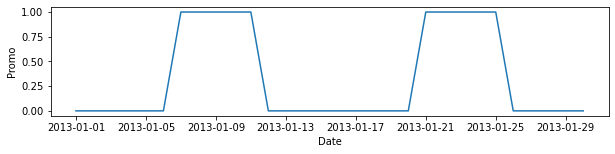

In [11]:
# Looking for pattern to fill in missing values in Promo column
promo_means_30_days = no_null_sales.groupby('Date').mean().head(30).loc[:,'Promo']
plt.figure(figsize=(10,2))
plt.plot(promo_means_30_days)
plt.ylabel('Promo')
plt.xlabel('Date')
plt.show()

In [12]:
# In this pattern it's safe to assume the missing value is 1: [1,1,NaN,1]
# In this pattern it's safe to assume the missing value is 0: [0,NaN,0,0]
# Slow loop
# TODO: Figure out fast, vectorized way to do this
null_promo = no_null_sales.loc[no_null_sales['Promo'].isnull()]

for i, row in null_promo.iterrows():
    try:
        above_and_below = no_null_sales.loc[i-1, 'Promo'] + no_null_sales.loc[i+1, 'Promo']
        if above_and_below == 2:
            no_null_sales.loc[i, 'Promo'] = 1
        elif above_and_below == 0:
            no_null_sales.loc[i, 'Promo'] = 0
    except:
        no_null_sales.loc[i, 'Promo'] = 0
        
null_promo = no_null_sales.loc[no_null_sales['Promo'].isnull()]

for i, row in null_promo.iterrows():
    date = str(row['Date'])
    mean = no_null_sales.groupby('Date').mean().loc[date, 'Promo']
    if mean > 0.9:
        no_null_sales.loc[i, 'Promo'] = 1
    else:
        no_null_sales.loc[i, 'Promo'] = 0

In [13]:
no_null_sales.to_csv('clean_data.csv', index = False)

### Stores dataframe

In [20]:
# count of null values in each column
stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
# Filling CompetitionDistance with the median for the corresponing StoreType
fillna_storetype_a = stores.groupby('StoreType').median().loc['a', 'CompetitionDistance']
fillna_storetype_b = stores.groupby('StoreType').median().loc['b', 'CompetitionDistance']
fillna_storetype_c = stores.groupby('StoreType').median().loc['c', 'CompetitionDistance']
fillna_storetype_d = stores.groupby('StoreType').median().loc['d', 'CompetitionDistance']
stores.loc[(stores['CompetitionDistance'].isnull()) & (stores.loc[:,'StoreType'] == 'a'), 'CompetitionDistance'] = fillna_storetype_a
stores.loc[(stores['CompetitionDistance'].isnull()) & (stores.loc[:,'StoreType'] == 'b'), 'CompetitionDistance'] = fillna_storetype_b
stores.loc[(stores['CompetitionDistance'].isnull()) & (stores.loc[:,'StoreType'] == 'c'), 'CompetitionDistance'] = fillna_storetype_c
stores.loc[(stores['CompetitionDistance'].isnull()) & (stores.loc[:,'StoreType'] == 'd'), 'CompetitionDistance'] = fillna_storetype_d

In [22]:
print(stores.isnull().sum())
print(f'\nNumber of rows in total: {stores.shape[0]}')

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Number of rows in total: 1115


In [23]:
# Too many missing values in the other columns, let's drop them for now.
# If there's time later on, we can come back and try to fill them in a meaningful way. 
stores = stores.loc[:,['Store', 'StoreType', 'Assortment', 'CompetitionDistance']]
stores.to_csv('stores_light.csv', index = False)